## Questions:
- how many unique question askers are there? Is it just the same people again and again? Does this create a bias? (e.g. there are an awful lot of questions on bees)
- there are lots of funny questions - what percentage of total? Maybe this shows people prefer the less-serious questions? Or are just science room people particularly comedic?
- look at percentage of questions on apocalypse, health, technology - seems people are particularly concered with mortality 
- very few engineering or chemistry questions?
- most physics questions are space or sound
- lots of food / nutrition questions 
- SO MUCH PSYCHOLOGY (is this a Jamal bias though?)


**Note**: every time I print out the dataframe, I have made sure not to include columns including surnames or other sensitive data, hence why you see a lot of 'drop' commands there.

## Import and process dataset

Import the dataset in and do some basic processing so that it's easier to analyse.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def dateparse(x):
    if x == 'Pilot':
        x = '14/06/2017'
    return pd.datetime.strptime(x, '%d/%m/%Y')

funnyparse = lambda x: False if x == 'n' else True

qs = pd.read_csv('sciroom_tagged.csv', skiprows=2, parse_dates=['When?'], date_parser=dateparse,
                 converters={'Funny':funnyparse, 'human':funnyparse})

In [3]:
qs.drop(['Name' ,'Other comments', 'Who?'], axis=1).head()

,When?,Questions,"Will this be a potential talk, blog post, or nothing?",Funny,human,Tags
0,2015-06-01,"""Could machines be conscious?""",Event,False,False,"technology, engineering, consciousness"
1,2015-06-01,"""Are we approaching to an ecological collapse?""",Event,False,False,"biology, apocalypse, ecology"
2,2015-06-01,"""Are we losing the war on disease?""",Event,False,True,"disease, apocalypse, medicine, biology"
3,2015-06-01,"""Is the nature of reality dependent on our obs...",Content: Read,False,True,"psychology, philosophy, reality"
4,2015-06-01,"""What inventions would we not have without the...",Event / Content,False,True,"engineering, space, technology"


In [4]:
qs.rename(columns={'When?':'date', 'Will this be a potential talk, blog post, or nothing? ':'output_type', 
                   'Who?':'who', 'Other comments':'comments', 'Name': 'first_name', 'Questions':'questions'}, inplace=True)

In [5]:
qs.insert(1, 'last_name', None)
for i, r in qs.iterrows():
    if r.last_name is None:
        try:
            names = r['first_name'].split(' ')
            if len(names) > 1:
                qs.set_value(i, 'first_name', names[0])
                qs.set_value(i, 'last_name', ' '.join(names[1:]))
        except AttributeError:
            pass

In [6]:
qs.drop(['last_name', 'comments', 'who'], axis=1).head(10)

,first_name,date,questions,output_type,Funny,human,Tags
0,Przemek,2015-06-01,"""Could machines be conscious?""",Event,False,False,"technology, engineering, consciousness"
1,Przemek,2015-06-01,"""Are we approaching to an ecological collapse?""",Event,False,False,"biology, apocalypse, ecology"
2,Philip,2015-06-01,"""Are we losing the war on disease?""",Event,False,True,"disease, apocalypse, medicine, biology"
3,Philip,2015-06-01,"""Is the nature of reality dependent on our obs...",Content: Read,False,True,"psychology, philosophy, reality"
4,Tim,2015-06-01,"""What inventions would we not have without the...",Event / Content,False,True,"engineering, space, technology"
5,Tim,2015-06-01,"""What inventions would we not have without war...",Event / Content,False,True,"anthropology, history, technology, engineering"
6,Tim,2015-06-01,"""How can science / technology make us happier?""",Event / Podcast,False,True,"technology, anthropology, neuroscience, psycho..."
7,Andrei,2015-06-01,"""What would the world be like without or with ...",Event / Content,False,False,"gravity, physics"
8,Abhi,2015-07-04,"""How do mirror neurons work?""",Content,False,True,"biology, neuroscience"
9,Reshma,2015-07-04,"""Can a machine identify cancer cell developing...",Event,False,True,"cancer, technology, medicine, biology"


Plot number of questions asked per month. You can see that there are drops around Christmas and Easter, as would be expected.

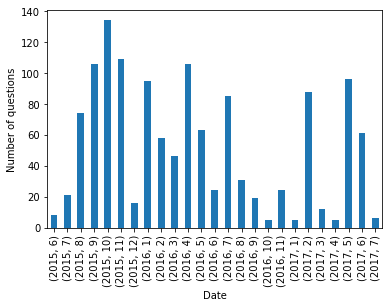

In [7]:
fig = qs[['date']].groupby([qs["date"].dt.year, qs["date"].dt.month]).count().plot(kind="bar", legend=False)
fig.set_xlabel('Date')
fig.set_ylabel('Number of questions')
plt.show()

Rudimentary classification of question types by looking at whether they contain words in the following lists.

In [8]:
# Note: to avoid selection bias, I'm going to need to classify a reasonable fraction of questions. 
# Otherwise e.g. I could just be counting the physics questions.

biology_words = ["ecological", "disease", "nature", "plants", "animals", "animal", "biology", "biological", 
                 "neurons", "cancer", "cell", "diet", "evolution", "human", "life", "zombie", "DNA",
                "species", "drunk", "nutrition", "virus", "drug", "exercise", "blood", "elephant", "bee", "cat"]
physics_words = ["space", "black hole", "star", "universe", "quantum", "physics", "radiation", "light", "moon",
                "mars", "wormhole", "turbulence", "time", "particles", "antimatter", "nuclear", "clock",
                "wavefunction", "electricity", "power", "gravity", "planet", "dimension", "gravitation", "telescope",
                "magnet", "vibrat", "big bang"]
chemistry_words = ["chemicals", "chemical", "metal", "chemistry", "material", "mineral", "fracking"]
psychology_words = ["psychology", "brain", "conscious", "mind", "memory", "memories"]

In [9]:
qs['genre'] = None

for i, r in qs.iterrows():
    # first try looking at the comments 
    
    try:
        comments = r['comments'].lower()
    except AttributeError:
        comments = ''
        
    if "biolog" in comments:
        qs.set_value(i, 'genre', 'biology')
    elif "physics" in comments:
            qs.set_value(i, 'genre', 'physics')
    elif "chemist" in comments:
        qs.set_value(i, 'genre', 'chemistry')
    elif "psycholog" in comments:
        qs.set_value(i, 'genre', 'psychology')    
    else: 
        for w in biology_words:
            if w in r['questions'].lower() + ' ' + comments:
                qs.set_value(i, 'genre', 'biology')
                break
        for w in physics_words:
            if w in r['questions'].lower() + ' ' + comments:
                qs.set_value(i, 'genre', 'physics')
                break
        for w in chemistry_words:
            if w in r['questions'].lower() + ' ' + comments:
                qs.set_value(i, 'genre', 'chemistry')
                break
        for w in psychology_words:
            if w in r['questions'].lower() + ' ' + comments:
                qs.set_value(i, 'genre', 'psychology')
                break

## Looking at tags and human / funny

Here, I'm going to look at the tags I've allocated to the questions to see which occur most frequently. I've also tagged each question with the properties 'human' and 'funny' - these are either true or false.

In [10]:
def tag_me(df):
    apocalypse = 0
    psychology = 0
    health = 0
    food = 0

    tag = pd.DataFrame(columns=['freq', 'funny', 'human'])

    for i, r in df.iterrows():
        try:
            if 'apocalypse' in r.Tags:
                apocalypse += 1
            if 'psychology' in r.Tags:
                psychology += 1
            if 'health' in r.Tags:
                health += 1
            if 'food' in r.Tags:
                food += 1

            ts = r.Tags.split(', ')
            for w in ts:
                if w[-1] == ' ':
                    w = w[:-1]
                try:
                    tag.set_value(w, 'freq', tag.loc[w]['freq'] + 1)
                except KeyError:
                    tag.loc[w] = 0
                    tag.set_value(w, 'freq', 1)
                if r.Funny:
                    tag.set_value(w, 'funny', tag.loc[w]['funny'] + 1)
                if r.human:
                    tag.set_value(w, 'human', tag.loc[w]['human'] + 1)
        except TypeError:
            pass

    print('apocalypse: \t', apocalypse/len(df), '\tpsychology: \t', psychology/len(df))
    print('health: \t', health/len(df), '\tfood: \t\t', food/len(df))
    tag.sort_values('freq', ascending=False, inplace=True)
    for i, r in tag.iterrows():
        tag.set_value(i, 'funny', r.funny / r.freq)
        tag.set_value(i, 'human', r.human / r.freq)
    return tag

tags = tag_me(qs)

apocalypse: 	 0.028527370855821126 	psychology: 	 0.28218966846569005
health: 	 0.11873554356206631 	food: 		 0.07710100231303008


In [11]:
sum(qs.Funny) / len(qs)

0.2336160370084811

In [12]:
sum(qs.human) / len(qs)

0.76175790285273703

Most common tags: you can see that biology, psychology and physics are the most popular tags. Technology and health also appear a lot - people ask a lot of questions about the future and about the treatment of disease / general health. Ecology pretty much means 'animals' - people quite like asking about these. As an astrophysicist, I'm pleased to see space is much higher than e.g. particle physics :D

In [13]:
tags.head(10)

,freq,funny,human
biology,447,0.270694,0.778523
psychology,366,0.155738,0.937158
physics,239,0.284519,0.401674
technology,197,0.228426,0.913706
health,154,0.0909091,0.993506
ecology,104,0.432692,0.346154
food,100,0.29,0.9
space,91,0.175824,0.428571
neuroscience,84,0.0952381,0.988095
philosophy,83,0.39759,0.843373


In [14]:
import plotly
plotly.offline.init_notebook_mode(connected=True)
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.tools as tls

This plot may not make the most sense as human and funny are not two variables we'd necessarily expect to be correlated, but it does show some interesting things. Zombie questions are always funny; cancer questions never are. Over 90% of technology questions are human-related - we're not so interested in whether cats will be conquering Mars any time soon. 

In [15]:
msize = lambda x: np.sqrt(np.float(x))

fig = tls.make_subplots(rows=1, cols=1)
x = tags.human
y = tags.funny
text = [i + ': ' + str(tags.loc[i]['freq']) for i in tags.index.values]
t = go.Scatter(x=x, y=y, mode='markers', text=text, 
               marker=dict(size=[3*x**0.5 for x in tags.freq], 
                          color=[3*x**0.5 for x in tags.freq],
                          colorscale='Viridis'))
fig.append_trace(t, 1, 1)

fig['layout']['xaxis1'].update(title='Human')
fig['layout']['yaxis1'].update(title='Funny')
fig['layout'].update(hovermode='closest')
plotly.offline.iplot(fig)

This is the format of your plot grid:
[ (1,1) x1,y1 ]



## Finding common question words

Comparing the frequency of query words like 'what', 'where', 'why' should tell us what people want to know and how they ask about things.

In [16]:
qword = dict()
# first find some query words
for i, r in qs.iterrows():
    w = r.questions.split(' ')[0][1:].split("'")[0].split(",")[0].lower()
    qword.setdefault(w, 0)
    qword[w] += 1
# run again using pandas filters so can pick up questions with query words that are not the first word 
# of the question string
for k, i in qword.items():
    if i >= 3:
        qword[k] = len(qs[qs.questions.str.contains(k) | qs.questions.str.contains(k.capitalize())])

# disregard non-query words
dropme = ['in', 'the', 'at', 'is', 'do', 'to']
for d in dropme:
    qword.pop(d)

In [17]:
for k in sorted(qword, key=qword.get, reverse=True):
    if qword[k] < 3:
        break
    print(k, qword[k])

what 301
how 282
why 230
are 207
if 192
does 171
can 153
could 81
would 77
will 63
when 54
where 34
should 31
did 25
which 18
who 18
has 17


In [18]:
labels = sorted(qword, key=qword.get, reverse=True)[:10]
values = [qword[k] for k in labels]
labels.append('other')
values.append(len(qs) - np.sum(np.array(values)))

trace = go.Pie(labels=labels, values=values, textinfo='label')
layout = go.Layout(title='Most common query words', showlegend=False)
fig = go.Figure(data=[trace], layout=layout)
plotly.offline.iplot(fig)

## Finding unique questioners & accounting for bias

Looking at whether our set of questions is dominated by the contributions from a small number of people and whether this biases our dataset.

In [19]:
questers = qs[['first_name', 'last_name']].drop_duplicates()
questers.drop('last_name', axis=1).head()

,first_name
0,Przemek
2,Philip
4,Tim
7,Andrei
8,Abhi


In [20]:
len(questers)

383

In [21]:
len(qs) / len(questers)

3.3864229765013056

This demonstrates we indeed have quite a few repeat questioners. Let's look at the most curious:

In [22]:
questers['freq'] = 0
for i, r in questers.iterrows():
    questers.set_value(i, 'freq', len(qs.loc[(qs.first_name == r.first_name) & (qs.last_name == r.last_name)]))

In [23]:
questers.sort_values('freq', ascending=False, inplace=True)
questers.drop('last_name', axis=1).head(10)

,first_name,freq
133,Jamal,84
502,Matt,46
520,Sean,36
125,Olly,33
142,John,25
2,Philip,25
69,Tom,23
371,Matt,21
4,Tim,20
53,Simon,17


In [24]:
questers['freq'].describe()

count    383.000000
mean       2.694517
std        6.487454
min        0.000000
25%        0.000000
50%        1.000000
75%        2.000000
max       84.000000
Name: freq, dtype: float64

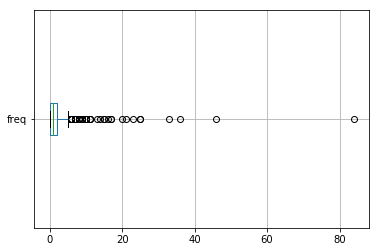

In [25]:
questers.boxplot('freq', vert=False)
plt.show()

In [26]:
trace = go.Box(x=questers.freq, name='All')
layout = go.Layout(title='Number of questions asked per person', showlegend=False)
fig = go.Figure(data=[trace], layout=layout)
plotly.offline.iplot(fig)

In [27]:
trace = go.Box(x=questers.iloc[15:].freq, name='Except top 15')
layout = go.Layout(title='Number of questions asked per person (excluding 15 most curious)', showlegend=False)
fig = go.Figure(data=[trace], layout=layout)
plotly.offline.iplot(fig)

Looking at that box plot, we see that indeed our dataset is dominated by contributions from just a few people. Let's see what percentage of the total questions are asked by the top 10 askers:

In [28]:
np.sum(questers.freq.head(10).values) / len(qs)

0.25443330763299921

That's over 25% of the questions which have been asked by just 10 people! This is likely to seriously bias our dataset, as these people are likely to ask questions on similar topics (e.g. Jamal tends to ask about psychology), making our dataset less representative of the general population. To tackle this, let's limit each person to the mean number of questions, rounded up (3). We'll select these randomly from their total questions, and run some analysis again a few times with different random selections to see if we get the same results. 

In [29]:
from random import sample
qs_unbiased = pd.DataFrame(columns=qs.columns)
for i, r in questers.iterrows():
    rs = qs.loc[(qs.first_name == r.first_name) & (qs.last_name == r.last_name)]
    if len(rs) > 3:
        s = sample(range(len(rs)), 3)
        rs = rs.iloc[s]
    qs_unbiased = qs_unbiased.append(rs)

In [30]:
qs_unbiased.drop(['last_name', 'comments', 'who'], axis=1).head(10)

,first_name,date,questions,output_type,Funny,human,Tags,genre
346,Jamal,2015-11-08,"""Does attraction to certain perceived 'persona...",NaN,False,True,psychology,None
521,Jamal,2016-01-31,"""Are we really brains?""",NaN,False,True,"psychology, neuroscience, philosophy",psychology
460,Jamal,2015-12-14,"""Does the real world have glitches?""",Event,False,True,"physics, reality",None
962,Matt,2016-08-27,"""Why do some numbers like e repeat themselves ...",NaN,False,False,maths,biology
1253,Matt,2017-06-06,"""Which is the grossest parasitic wasp?""",NaN,True,False,"biology, ecology",None
505,Matt,2016-01-04,"""How is biotech changing medical treatments?""",NaN,False,True,"biology, medicine, health, technology",None
900,Sean,2016-07-26,"""Are there Lesser Danes? Do they feel bad abou...",NaN,True,False,"ecology, psychology",None
770,Sean,2016-04-26,"""Can we ever simulate the universe?""",NaN,False,True,"technology, computer science",physics
1054,Sean,2017-02-22,"""What's the best drug?""",NaN,False,True,"medicine, biology, health",biology
828,Olly,2016-05-31,"""How do plant immune systems work?""",NaN,False,True,"biology, ecology",None


In [31]:
len(qs_unbiased)

479

In [32]:
tags_u = tag_me(qs_unbiased)

apocalypse: 	 0.022964509394572025 	psychology: 	 0.2546972860125261
health: 	 0.10647181628392484 	food: 		 0.08350730688935282


In [33]:
tags = tag_me(qs)

apocalypse: 	 0.028527370855821126 	psychology: 	 0.28218966846569005
health: 	 0.11873554356206631 	food: 		 0.07710100231303008


In [34]:
tags_u.head(10)

,freq,funny,human
biology,159,0.327044,0.792453
psychology,122,0.172131,0.918033
physics,96,0.322917,0.46875
technology,82,0.207317,0.939024
health,51,0.0588235,1
food,40,0.25,0.875
ecology,40,0.525,0.375
space,36,0.194444,0.527778
neuroscience,30,0.0666667,1
medicine,30,0.1,0.966667


In [35]:
tags.head(10)

,freq,funny,human
biology,447,0.270694,0.778523
psychology,366,0.155738,0.937158
physics,239,0.284519,0.401674
technology,197,0.228426,0.913706
health,154,0.0909091,0.993506
ecology,104,0.432692,0.346154
food,100,0.29,0.9
space,91,0.175824,0.428571
neuroscience,84,0.0952381,0.988095
philosophy,83,0.39759,0.843373


In [36]:
for i, t in tags_u.head(10).iterrows():
    print(i, '\t', t.freq / len(qs_unbiased))

biology 	 0.33194154488517746
psychology 	 0.2546972860125261
physics 	 0.20041753653444677
technology 	 0.17118997912317327
health 	 0.10647181628392484
food 	 0.08350730688935282
ecology 	 0.08350730688935282
space 	 0.07515657620041753
neuroscience 	 0.06263048016701461
medicine 	 0.06263048016701461


In [37]:
for i, t in tags.head(10).iterrows():
    print(i, '\t', t.freq / len(qs))

biology 	 0.3446414803392444
psychology 	 0.28218966846569005
physics 	 0.18427139552814187
technology 	 0.15188897455666925
health 	 0.11873554356206631
ecology 	 0.08018504240555127
food 	 0.07710100231303008
space 	 0.07016191210485737
neuroscience 	 0.06476484194294525
philosophy 	 0.06399383191981496


This is actually pretty encouraging: the top 10 most popular tags are more or less the same, as are the percentages with which they occur and their funnyness / humanity. This suggests that although our dataset may be dominated by the contributions from a relatively small number of people, their contributions are largely representative of the total population and do not appear to bias the results significantly. We can therefore continue our analysis with the complete dataset. 

## Looking at output

In [38]:
qs.output_type

0                               Event
1                               Event
2                               Event
3                       Content: Read
4                     Event / Content
5                     Event / Content
6                     Event / Podcast
7                     Event / Content
8                             Content
9                               Event
10                              Event
11           Content: Read (multiple)
12           Content: Read (multiple)
13                              Event
14                              Event
15                            Content
16                  Content (Podcast)
17           Content: Read (multiple)
18                              Event
19                              Event
20                              Event
21                            Content
22                              Event
23                              Event
24                   Content: Podcast
25                  Event (Podcast?)^
26          

In [39]:
output_types = {'event':0, 'podcast':0, 'content':0, 'infographic':0, 'read':0}

for k, _ in output_types.items():
    output_types[k] = len(qs[qs.output_type.str.contains(k) | qs.output_type.str.contains(k.capitalize())])

In [40]:
for k in sorted(output_types, key=output_types.get, reverse=True):
    print(k, '   \t', output_types[k])

event    	 250
content    	 223
read    	 223
podcast    	 70
infographic    	 11


Note: doesn't look like there was much consistancy with the 'content' label, so not sure how useful this will be.